In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from matplotlib.path import Path


In [14]:

# ============================================================
# --- VORONOI HELPERS ---
# ============================================================

def voronoi_finite_polygons_2d(vor, radius=1000):
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    all_ridges = {}

    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for p1, region_index in enumerate(vor.point_region):
        region = vor.regions[region_index]
        if -1 not in region:
            new_regions.append(region)
            continue

        ridges = all_ridges[p1]
        new_region = [v for v in region if v != -1]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue

            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            new_vertices.append(far_point.tolist())
            new_region.append(len(new_vertices) - 1)

        new_regions.append(new_region)

    return new_regions, np.array(new_vertices)

def sort_polygon(points):
    center = points.mean(axis=0)
    angles = np.arctan2(points[:,1] - center[1], points[:,0] - center[0])
    return points[np.argsort(angles)]


In [15]:

# ============================================================
# --- SIMULATION PARAMETERS ---
# ============================================================

WIDTH = 380
HEIGHT = 280
NUM_DISTRICTS = 8       # Number of districts
NUM_DOTS = 1000          # Number of voters
parties = 0
COLORS = ['red', 'blue', 'green'] # Parties (for efficiency gap and PR)
NUM_RUNS = 1000           # Number of simulations

# ============================================================
# --- CREATE FIXED DISTRICT MAP (run once) ---
# ============================================================

points = np.random.rand(NUM_DISTRICTS, 2)
points[:,0] *= WIDTH
points[:,1] *= HEIGHT
vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor)

# Store fixed district polygons
district_polygons = []
for region in regions:
    polygon = vertices[region]
    if len(polygon) < 3:
        district_polygons.append(None)
    else:
        district_polygons.append(sort_polygon(polygon))


In [16]:

# ============================================================
# --- FUNCTION: run one election with random voters ---
# ============================================================

def run_election():
    """
    Generates random voters and counts them per district.
    Returns:
        dots_x, dots_y, dots_colors, district_counts
    """
    dots_x = np.random.rand(NUM_DOTS) * WIDTH
    dots_y = np.random.rand(NUM_DOTS) * HEIGHT
    dots_colors = np.random.choice(COLORS, NUM_DOTS)

    district_counts = []
    for polygon in district_polygons:
        counts = {color: 0 for color in COLORS}
        if polygon is None:
            district_counts.append(counts)
            continue
        poly_path = Path(polygon)
        mask = poly_path.contains_points(np.column_stack((dots_x, dots_y)))
        for color, inside in zip(dots_colors, mask):
            if inside:
                counts[color] += 1
        district_counts.append(counts)

    return dots_x, dots_y, dots_colors, district_counts



In [17]:
#=================================
# Effieciency Gaps
#=================================

def efficiency_gc(district_counts):
    efficiency_gaps=[]

    for index in range(len(district_counts)):
        party=max(district_counts[index].items(), key=lambda item: item[1])[0]
        num_winning_votes=district_counts[index][party]

        temp=0
        for keys in district_counts[index]:
            temp=temp+district_counts[0][keys]

        num_votes_in_district=temp

        num_losing_votes=num_votes_in_district-num_winning_votes

        wasted_winner=num_winning_votes-(num_votes_in_district/3)
        wasted_loser=num_losing_votes

        efficiency_gap=(wasted_winner-wasted_loser)/num_votes_in_district
        efficiency_gaps.append(efficiency_gap)


    return efficiency_gaps
    gaps = efficiency_gc(district_counts)
    print(gaps)


In [18]:
# ============================================================
# --- FUNCTION: calculate proportional representation ---
# ============================================================

def calculate_PR(district_counts):
    """
    Returns a dictionary of allocated seats per party using largest remainder method.
    """
    NUM_SEATS = NUM_DISTRICTS

    # Compute statewide votes
    statewide_votes = {color: 0 for color in COLORS}
    for district in district_counts:
        for color in COLORS:
            statewide_votes[color] += district[color]

    total_votes = sum(statewide_votes.values())
    exact_seats = {color: (statewide_votes[color]/total_votes)*NUM_SEATS for color in COLORS}

    # Assign integer seats first
    allocated_seats = {color: int(exact_seats[color]) for color in COLORS}
    remaining_seats = NUM_SEATS - sum(allocated_seats.values())

    # Largest remainder method
    remainders = {color: exact_seats[color] - allocated_seats[color] for color in COLORS}
    sorted_by_remainder = sorted(COLORS, key=lambda c: remainders[c], reverse=True)
    for i in range(remaining_seats):
        allocated_seats[sorted_by_remainder[i]] += 1

    return statewide_votes, allocated_seats


In [19]:
# ============================================================
# --- RUN SIMULATIONS ---
# ============================================================

all_results = []

for run in range(NUM_RUNS):
    dots_x, dots_y, dots_colors, district_counts = run_election()
    statewide_votes, allocated_seats = calculate_PR(district_counts)
# NEW: compute efficiency gaps for this run 
    efficiency_gaps = efficiency_gc(district_counts)

    all_results.append({
        'statewide_votes': statewide_votes,
        'allocated_seats': allocated_seats,
        'dots_x': dots_x,
        'dots_y': dots_y,
        'dots_colors': dots_colors,
        'efficiency_gaps': efficiency_gaps
    })
    


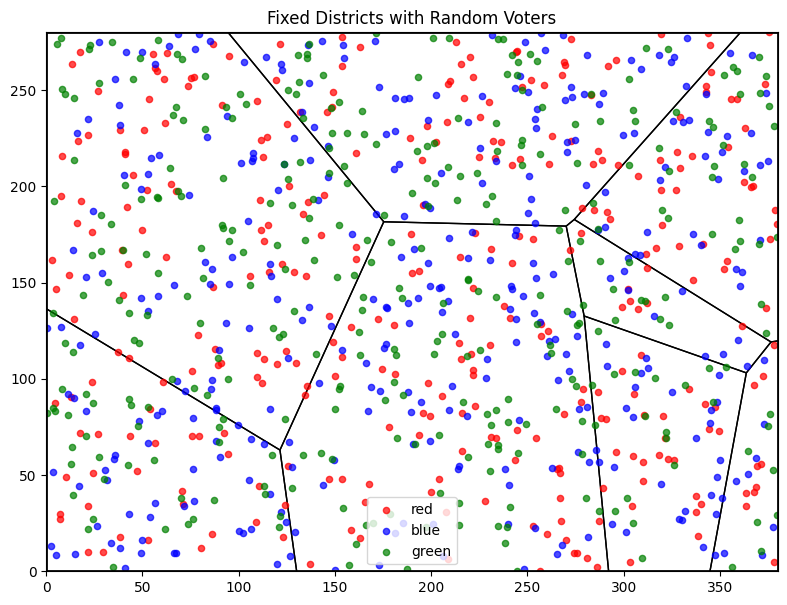

After loop, len(all_results) = 1000

--- Simulation 1 ---
Statewide votes: {'red': 321, 'blue': 344, 'green': 335}
red Vote/Total Vote: 0.321
blue Vote/Total Vote: 0.344
green Vote/Total Vote: 0.335
District 1: {'red': 7, 'blue': 11, 'green': 6}
District 2: {'red': 65, 'blue': 85, 'green': 75}
District 3: {'red': 52, 'blue': 51, 'green': 50}
District 4: {'red': 6, 'blue': 11, 'green': 6}
District 5: {'red': 32, 'blue': 28, 'green': 26}
District 6: {'red': 42, 'blue': 44, 'green': 56}
District 7: {'red': 93, 'blue': 99, 'green': 87}
District 8: {'red': 17, 'blue': 19, 'green': 32}
Allocated seats: {'red': 2, 'blue': 3, 'green': 3}
Efficiency Gap: [-0.5925925925925926, 5.037037037037037, 2.2222222222222223, -0.5185185185185185, 1.2592592592592593, 3.5555555555555554, 4.962962962962963, 0.7407407407407407]
Std Dev of Efficiency Gaps: 2.109953386257874

--- Simulation 2 ---
Statewide votes: {'red': 341, 'blue': 331, 'green': 328}
red Vote/Total Vote: 0.341
blue Vote/Total Vote: 0.331
green

In [20]:
# ============================================================
# ---  visualize one run ---
# ============================================================

run_to_show = 0
dots_x = all_results[run_to_show]['dots_x']
dots_y = all_results[run_to_show]['dots_y']
dots_colors = all_results[run_to_show]['dots_colors']

fig, ax = plt.subplots(figsize=(10,7))
for polygon in district_polygons:
    if polygon is not None:
        ax.fill(polygon[:,0], polygon[:,1], edgecolor='black', fill=False, linewidth=1)

for color in COLORS:
    ax.scatter(dots_x[dots_colors==color], dots_y[dots_colors==color], c=color, label=color, s=20, alpha=0.7)

ax.plot([0, WIDTH, WIDTH, 0, 0], [0,0,HEIGHT,HEIGHT,0], color='black', linewidth=2)
ax.set_xlim(0, WIDTH)
ax.set_ylim(0, HEIGHT)
ax.set_aspect('equal')
ax.set_title('Fixed Districts with Random Voters')
ax.legend()
plt.show()

# ============================================================
# --- SHOW RESULTS ---
# ============================================================
print("After loop, len(all_results) =", len(all_results))

arr=[]
for i, result in enumerate(all_results[:1000]):  # show first 5 runs
    print(f"\n--- Simulation {i+1} ---")
    
    statewide = result['statewide_votes']
    total_votes = sum(statewide.values())

    print("Statewide votes:", statewide)

    # Print each party's vote share
    for party, votes in statewide.items():
        print(f"{party} Vote/Total Vote:", votes / total_votes)
    for i, counts in enumerate(district_counts):
        print(f"District {i+1}: {counts}")


    print("Allocated seats:", result['allocated_seats'])
    print("Efficiency Gap:", result['efficiency_gaps'])
    gaps = result['efficiency_gaps'] 
    std_gap = np.std(gaps) 
    print("Std Dev of Efficiency Gaps:", std_gap)
    arr.append(std_gap)





In [22]:
print(arr)

[np.float64(2.109953386257874), np.float64(2.0029518941129854), np.float64(2.3165183117875157), np.float64(3.056550343115585), np.float64(1.7237514143882868), np.float64(3.3319441549719664), np.float64(2.216300926300029), np.float64(2.264133848369688), np.float64(3.567609750964931), np.float64(1.7931776574313854), np.float64(2.3494264250554795), np.float64(2.1798165060389834), np.float64(1.5853879213338014), np.float64(2.5380842097094725), np.float64(1.960528061674264), np.float64(1.953394947525915), np.float64(2.5739534368158314), np.float64(2.8725773584486993), np.float64(2.2355510751193886), np.float64(2.6716577441807208), np.float64(1.885028735413159), np.float64(2.0819748657377652), np.float64(2.355917490537863), np.float64(1.828561873594876), np.float64(2.8884936717275282), np.float64(2.2122699459174204), np.float64(2.8812589075891784), np.float64(1.578684546690435), np.float64(2.6117509282382034), np.float64(2.1131120052990036), np.float64(2.113059529717913), np.float64(2.878259

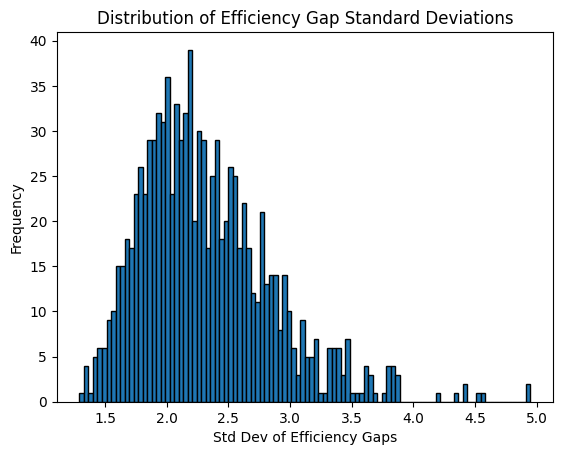

In [23]:
plt.hist(arr, bins=100, edgecolor='black')
plt.xlabel("Std Dev of Efficiency Gaps")
plt.ylabel("Frequency")
plt.title("Distribution of Efficiency Gap Standard Deviations")
plt.show()


In [ ]:
#Goal: Find a way to have every district have approxiamately the same number of voters